In [2]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data, axis=False):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")

    if not axis:
        plt.axis("off")

In [4]:
def plot_multi(img,start=0,end=100):
    plt.figure(figsize=(9, 9))
    for idx, image_data in enumerate(img[start:end]):
        plt.subplot(10, 10, idx + 1)
        plot_digit(image_data)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## data preparation

In [5]:
from pathlib import Path

# this is where the datasets are located
path = Path() / "dataset_cleaned"
print(path)

dataset_cleaned


In [6]:
# your training datasets
# must be cleaned

my_data_num = np.load(path / "digit_data_TrVal_corrected.npz")
my_data_sym = np.load(path / "op_data_TrVal_corrected.npz")

## visualization

this is just for checking, unnecessary

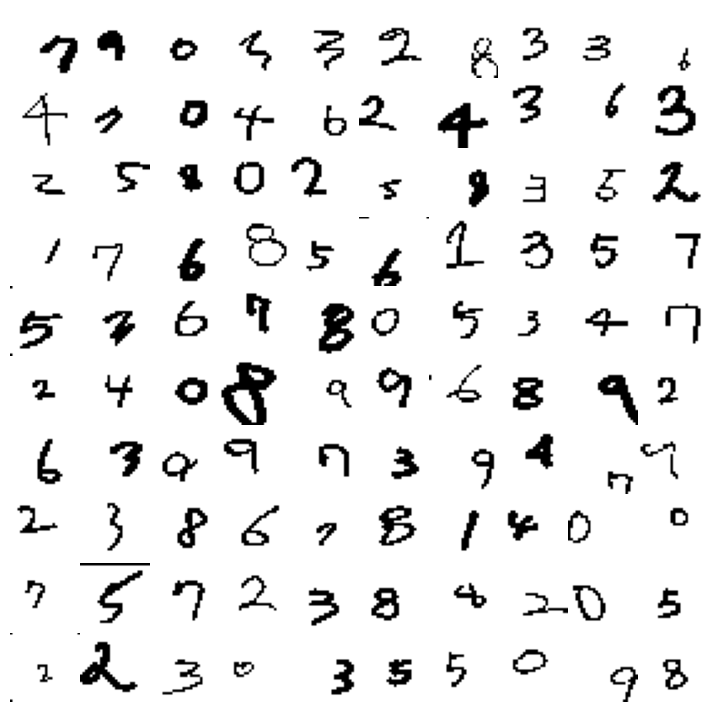

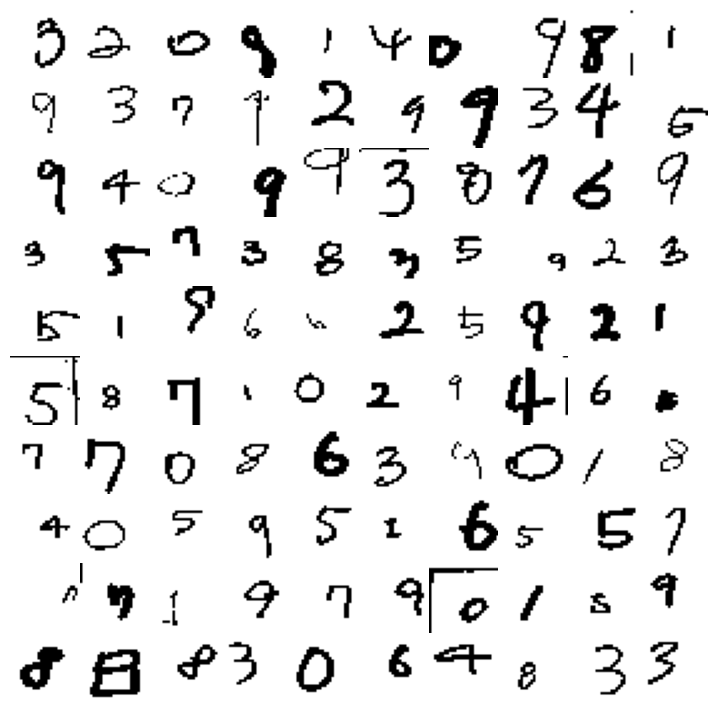

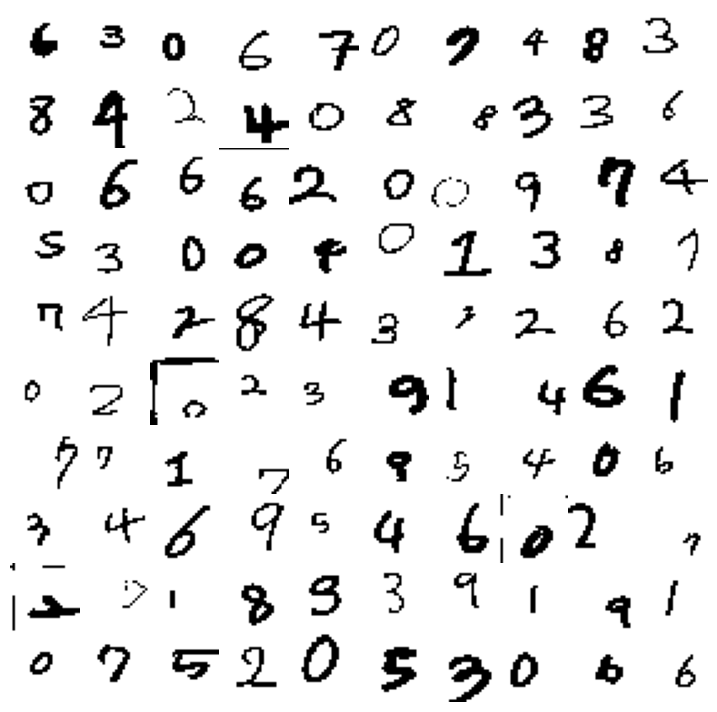

In [7]:
for i in range(3):
    plot_multi(my_data_num["img"],i * 100,i * 100 + 100)

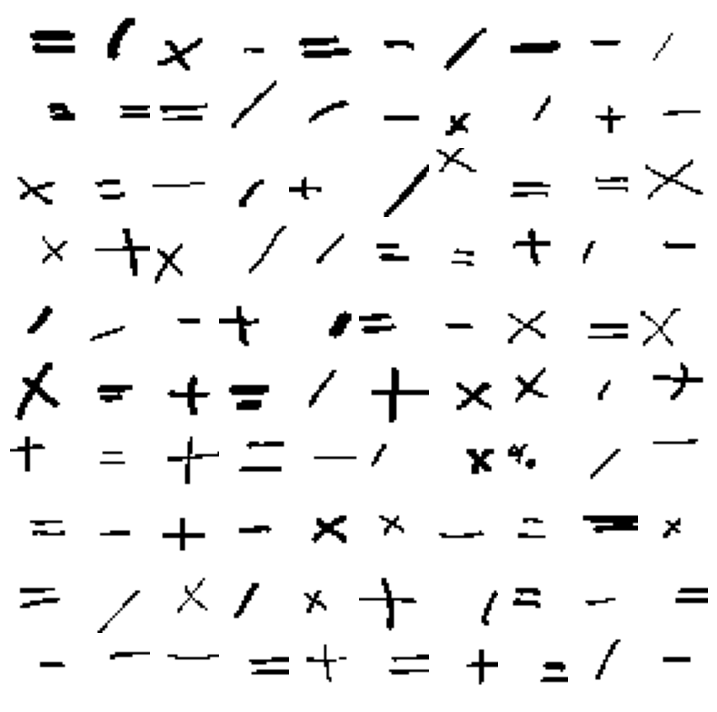

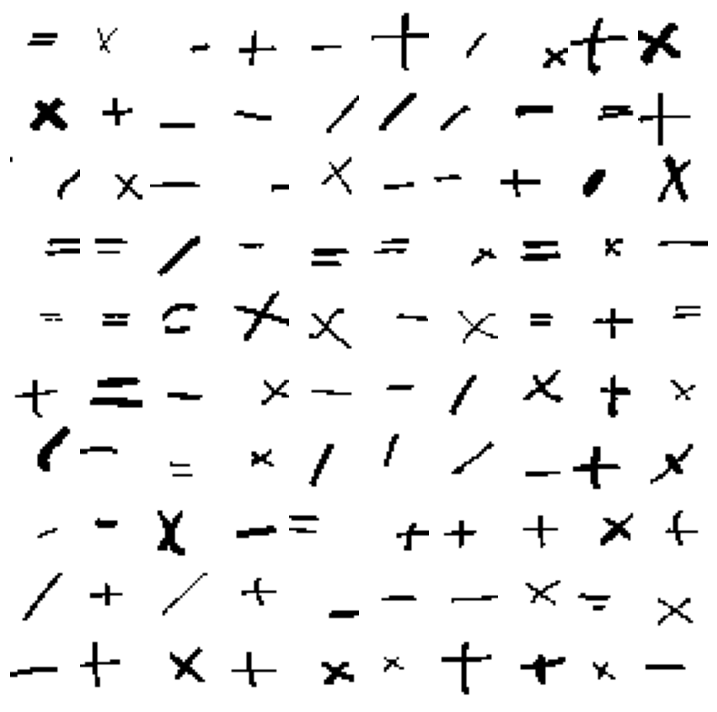

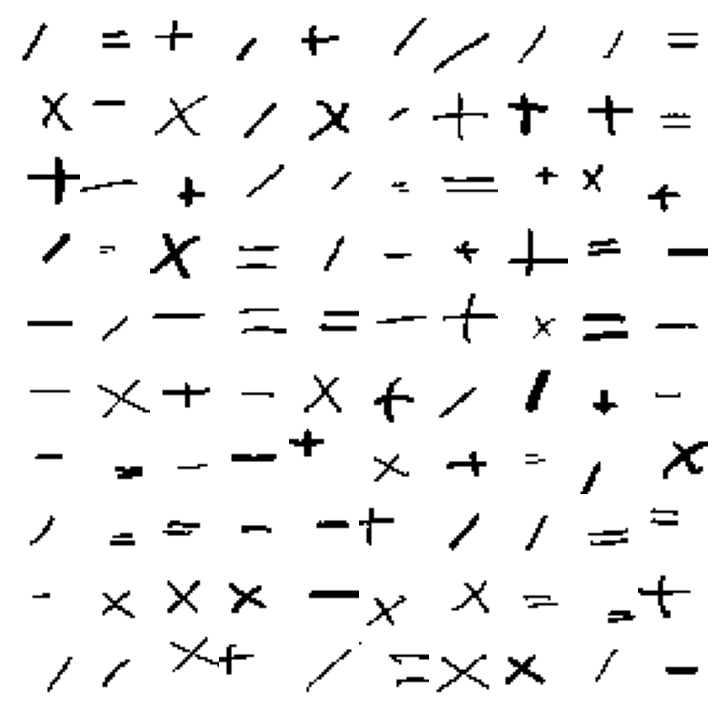

In [8]:
for i in range(3):
    plot_multi(my_data_sym["img"],i * 100,i * 100 + 100)

## preprocessing

1. rebase
2. border deletion
3. dot deletion
4. resize

In [9]:
def rebase_center(img):
    r = 28
    c = 28

    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1

    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
    
    # print(r_top,r_bot,c_left,c_right)
    
    c_len = c_right - c_left + 1
    r_len = r_bot - r_top + 1

    c_start = int((c - c_len) / 2)
    r_start = int((r - r_len) / 2)

    # print(c_len,r_len,c_start,r_start)

    rebased_data = np.zeros((r,c),dtype="float64")

    # rebase into a center
    rebased_data[r_start:r_start+r_len, c_start:c_start+c_len] = img[r_top:r_bot+1, c_left:c_right+1]
    
    return rebased_data

check the **npzRebase.ipynb** for details

In [10]:
def detect_del_boundary(img, thickness = 4, threshold = 10):
    curr = np.reshape(img,(28,28))
    
    # how much you want to look at
    t = thickness
    # the threshold
    threshold_t = threshold
    
    cnt_top = np.count_nonzero(curr[0:t,:])
    cnt_down = np.count_nonzero(curr[28-t:28,:])
    cnt_left = np.count_nonzero(curr[:,0:t])
    cnt_right = np.count_nonzero(curr[:,28-t:28])
    
    flag = False
    
    if cnt_top > threshold_t:
        curr[0:t,:] = 0.
        flag = True
    
    if cnt_down > threshold_t:
        curr[28-t:28,:] = 0.
        flag = True
    
    if cnt_left > threshold_t:
        curr[:,0:t] = 0.
        flag = True
        
    if cnt_right > threshold_t:
        curr[:,28-t:28] = 0.
        flag = True
    
    return rebase_center(curr) if flag is True else curr

check the **npzBorderDel.ipynb** for details

here we will run **rebase_center** if the boundary is deleted

In [11]:
def dfs(r,c,img, visited):
    st = list()
    st.append([r,c])
    
    cord = [[1,1],[1,0],[1,-1],[0,1],[0,-1],[-1,1],[-1,0],[-1,-1]]
    
    dot = list()
    
    while st:
        curr = st.pop()
        
        if visited[curr[0]][curr[1]] == 1.: continue
        
        dot.append(curr)
        visited[curr[0]][curr[1]] = 1.
        
        for n,m in enumerate(cord):
            row = curr[0] + m[0]
            col = curr[1] + m[1]
            
            if 0 <= row < 28 and 0 <= col < 28:
                if img[row][col] != 0. and visited[row][col] == 0.:
                    st.append([row,col])
            
    
    return dot,visited

In [12]:
def d_deletion(img, dot_size = 4):
    
    # to check whether we visited
    isVisited = np.full((28,28),0.)
    
    # dots that needs to be deleted afterwards
    dots = list()
    
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0. and not isVisited[i][j]:
                dot, isVisited = dfs(i,j,img,isVisited)
                
                if len(dot) <= dot_size:
                    dots.extend(dot)
    
    
        for n,m in enumerate(dots):
            img[m[0],m[1]] = 0.
    
    return img

In [26]:
def resize(img,size=18):
    
    
    r = 28
    c = 28
    
    # each boundary
    r_top = r
    r_bot = -1
    c_left = c
    c_right = -1
    
    for n in range(r):
        for m in range(c):
            
            # if the pixel has whatever value
            if img[n][m] != 0:
                # update the boundary
                r_top = min(r_top, n)
                r_bot = max(r_bot, n)
                c_left = min(c_left, m)
                c_right = max(c_right, m)
                
    import cv2
    try:
        # using inter_nearest
        resized_img = cv2.resize(img[r_top:r_bot+1,c_left:c_right+1], dsize=(size,size),interpolation=0)
    except:
        return img
        
    resized_img = np.pad(resized_img,int((28 - size)/2),mode="constant")
    
    return resized_img

check the **npzThickening.ipynb** for details

In [27]:
def preprocessing(img, rebase=True, b_del=True, d_del=True, re_size=True, one_array=True):
    size = np.shape(img)[0]
    
    # row and column length
    r = 28
    c = 28
    
    # reshape to 2-d array(for convenience)
    img_preprocessed = np.reshape(img,(size,r,c))
    
    # rebase
    if rebase:
        print("rebase ongoing")
        
        for x in range(size):
            img_preprocessed[x] = rebase_center(img_preprocessed[x])
        print("done!")
    
    # border deletion
    if b_del:
        print("border deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = detect_del_boundary(img_preprocessed[x])
            
        print("done!")
    
    # dot deletion
    if d_del:
        print("dot deletion ongoing")
        
        for x in range(size):
            img_preprocessed[x] = d_deletion(img_preprocessed[x])
            
        print("done!")
    
    # resize
    if re_size:
        print("resize ongoing")
        
        for x in range(size):
            img_preprocessed[x] = resize(img_preprocessed[x])
        
        print("done!")
    
    return np.reshape(img_preprocessed,(size,r*c)) if one_array else np.reshape(img_preprocessed,(size,r,c))

In [28]:
my_data_num_img_preprocessed = preprocessing(my_data_num["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


In [30]:
my_data_sym_img_preprocessed = preprocessing(my_data_sym["img"]).copy()

rebase ongoing
done!
border deletion ongoing
done!
dot deletion ongoing
done!
resize ongoing
done!


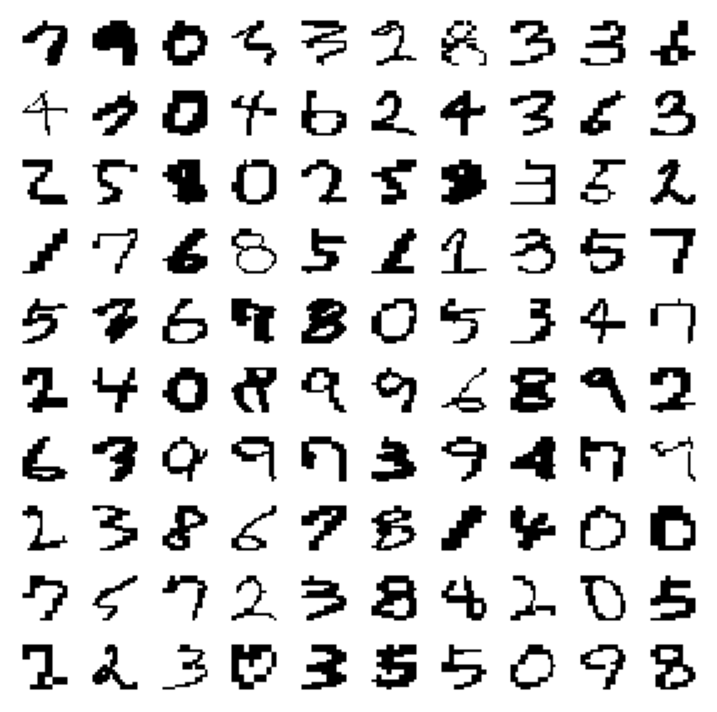

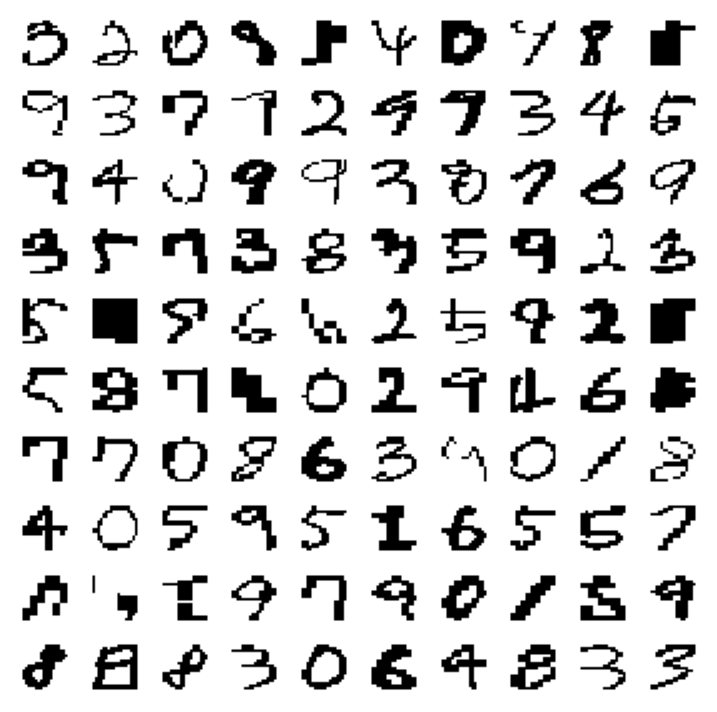

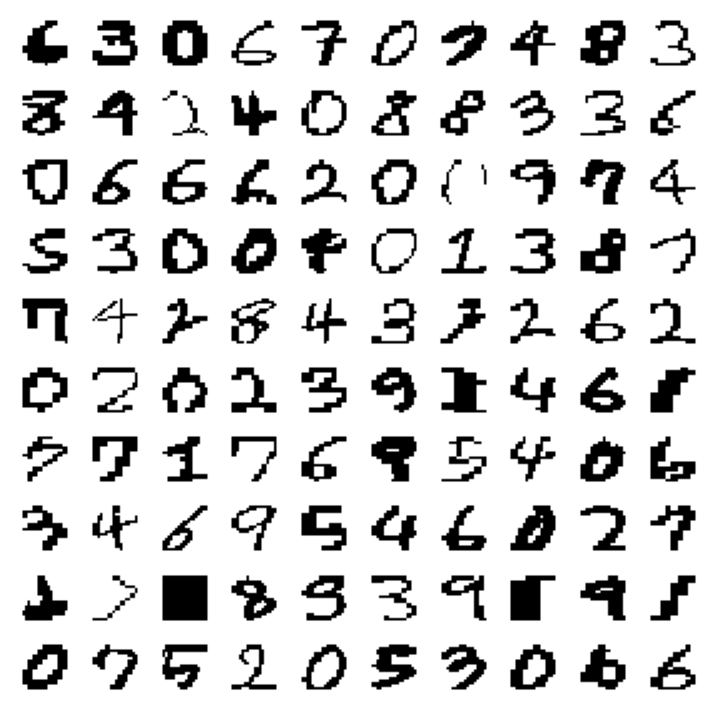

In [31]:
for i in range(3):
    plot_multi(my_data_num_img_preprocessed,i * 100,i * 100 + 100)

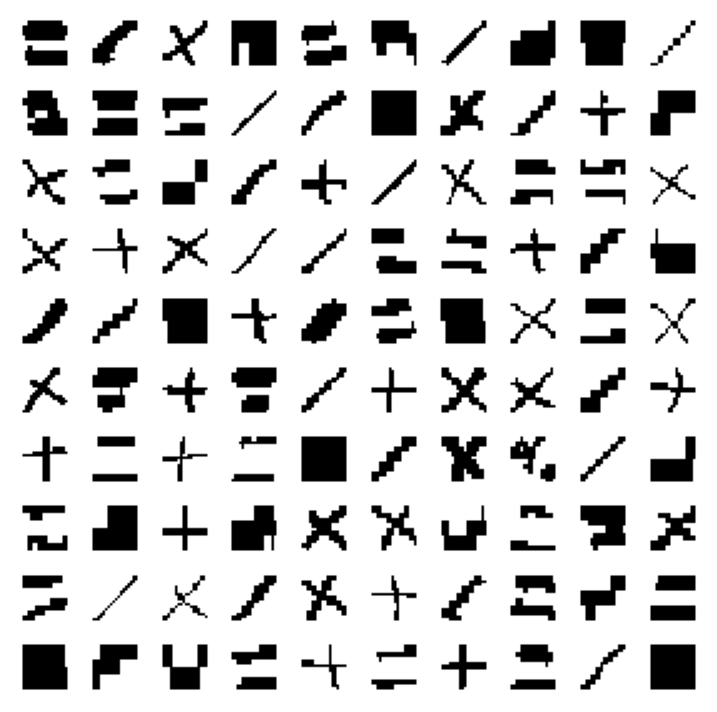

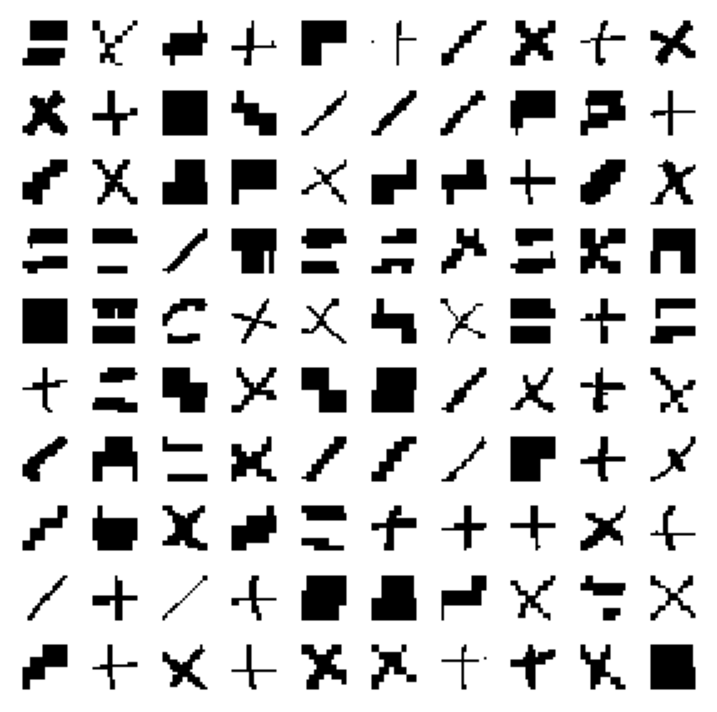

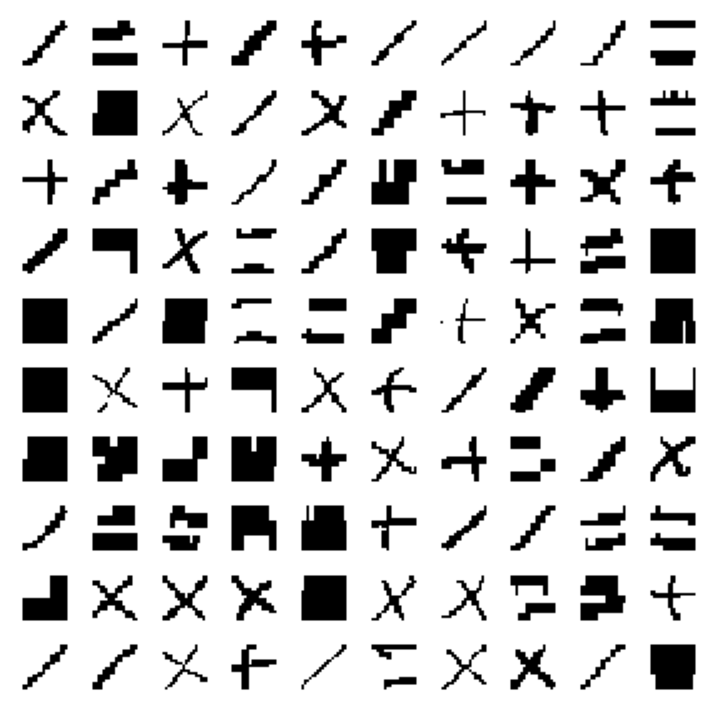

In [32]:
for i in range(3):
    plot_multi(my_data_sym_img_preprocessed,i * 100,i * 100 + 100)

## model training

In [15]:
# your model here

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

random = 42

# 먼저 random_state을 제외한 모든 hyperparameter를 default를 둔 채 fit
# StandardScaler 대신 RobusterScaler 사용
nn_clf = make_pipeline(RobustScaler(), MLPClassifier(random_state=random,solver="lbfgs",max_iter=300))
nn_clf.fit(my_data_num_img_preprocessed, my_data_num["label"])

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=300, random_state=42, solver='lbfgs'))])

## model validation

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(nn_clf, my_data_num_img_preprocessed, my_data_num["label"], cv=5)

array([0.76006768, 0.77428088, 0.77123519, 0.75905245, 0.71099831])

## model final test

In [31]:
nn_clf.predict_proba(np.reshape(my_data_num_img_preprocessed[10],(1,-1)))[0,4]

0.9999999997708593

In [32]:
my_data_num["label"][10]

'4'